### Culling выборки для достижения неизбыточности. FreeSASA, DSSP.

Мы воспользовались готовым набором белков, предоставленным PISCES. Из 44921 указанных в нашем наборе белков, нам удалось скачать из PDB 40910. Во наборе PISCES указаны не просто белки, а конкретные цепи белков. Мы, соответственно, будем всегда следить за тем, чтобы рассматривать только нужные цепи:

In [1]:
pisces_prot_to_chain = dict()
with open('./PISCES_nonredundant_pdb_chains.txt', 'r') as all_chains_file:
    all_chains = all_chains_file.readlines()

for ind, line in enumerate(all_chains):
    if (ind == 0):
        continue
    l = line.strip().split()
    pdbid = l[0][:4]
    chain = l[0][4]
    if (pdbid not in pisces_prot_to_chain):
        pisces_prot_to_chain[pdbid] = set()
    pisces_prot_to_chain[pdbid].add(chain)

В этом проекте у нас будет два основных типа данных. <br>
Во-первых, это данные о площади поверхности отдельных остатков внутри рассматриваемых нами белков. Эти данные мы получили, воспользовавшись открытым кодом FreeSASA (Simon Mitternacht, 2016). Мы использовали имплементированный в этом наборе программ алгоритм, разработанный Shrake & Rupley (он известен как 'rolling ball'). В качестве растворителя мы брали воду (радиус = 1.4 Å). <br>
Во-вторых, это аннотация вторичной структуры рассматриваемых белков, полученная с помощью алгоритма DSSP.

In [2]:
freesasa_dir = './FreeSASA_output/'
dssp_dir = './DSSP_output/'

### Глобулярная модель структуры белка.

Здесь мы рассмотрим соответствие наших данных глобулярной модели структуры белка. Мы будем фиксировать наше внимание в основном не на отдельных остатках, а на данных по белку в целом. <br>

В рамках глобулярной модели белка площадь поверхности растет пропорционально квадрату радиуса, а объем (который соразмерен количеству аминокислот) будет расти пропорционально кубу радиуса. Проверим, выполняется ли такая корреляция для рассматриваемых белков.

processing freeSASA files: 100%|██████████| 40910/40910 [00:15<00:00, 2588.96it/s]


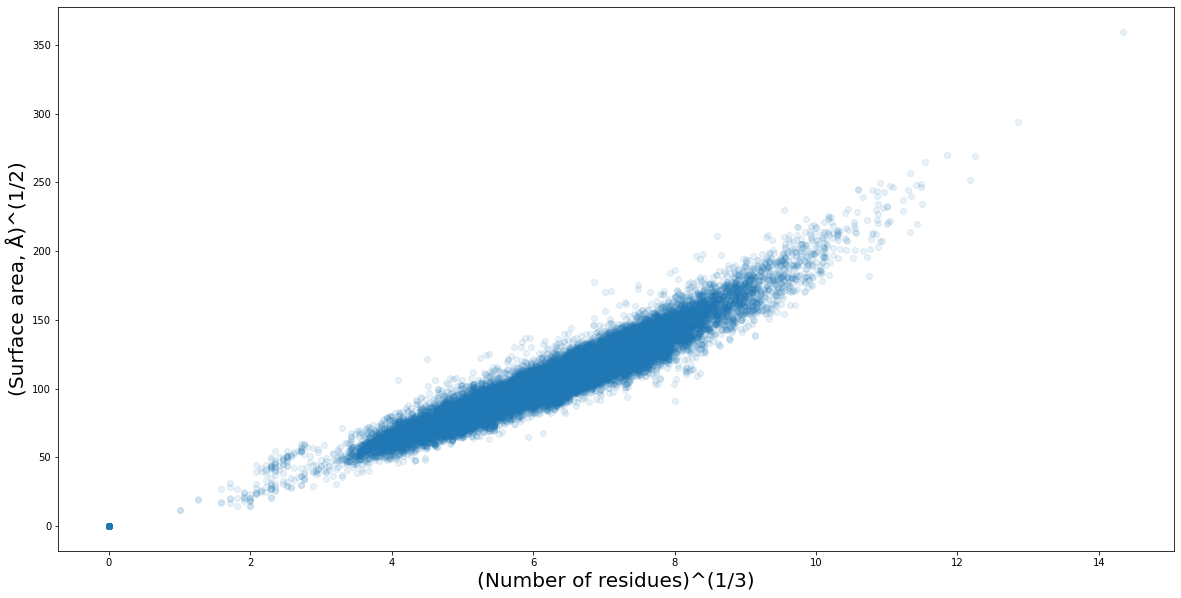

In [3]:
from tqdm import tqdm
import os 


protlen_vs_surfarea = [['pdb_id', 'number_of_residues', 'surface_area']]

for ind, f in enumerate(tqdm(os.listdir(freesasa_dir), desc='processing freeSASA files')):
    pdbid = f.split('.')[0]
    seqlen = 0
    surfarea = 0
    chain_set = pisces_prot_to_chain[pdbid]
    with open(freesasa_dir + f, 'r') as sasa_file:
        for line in sasa_file:
            if (line.startswith('#') or line == '\n'):
                continue
            l = line.strip().split()
            if (l[1] not in chain):
                continue
            seqlen += 1
            surfarea += float(l[5])
    protlen_vs_surfarea.append([pdbid, seqlen, surfarea])
    
    
import pandas as pd
import numpy as np

protlen_vs_surfarea = pd.DataFrame(protlen_vs_surfarea[1:], columns=protlen_vs_surfarea[0])
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
x_vals = np.power(protlen_vs_surfarea['number_of_residues'], 1/3)
y_vals = np.power(protlen_vs_surfarea['surface_area'], 1/2)
plt.scatter(x_vals, y_vals, alpha=.1)
plt.xlabel('(Number of residues)^(1/3)', fontsize=20)
plt.ylabel('(Surface area, Å)^(1/2)', fontsize=20)
plt.show()

Мы видим достаточно хорошую корреляцию. Она похожа на линейную, однако стоит отметить, что имеется значительный разброс для белков, длина которых превосходит 50 аминокислотных остатков. Мы предполагаем, что это следствие того, что белки не обязаны иметь форму буквально шара. Если предположить, что часть белков имеет эллиптическую форму, или форму изогнутых эллипсов и тд., то взятое нами отношение как раз не должно идеально ложиться на прямую.
<br>

Далее мы будем рассматривать в том числе уже площади отдельных остатков. Так как мы априори знаем, что остатки имеют существенно разный размер, то вклад этого эффекта в наши наблюдения нам неинтересен. Поэтому воспользуемся данными Tien et al., 2013 ('Maximum Allowed Solvent Accessibilites of Residues in Proteins') о максимальной возможной доступной для воды поверхности остатка X в трипептиде Gly-X-Gly (согласно совету авторов, мы будем брать теоретические, а не экспериментальные значения). Будем нормировать площади, выданные freeSASA, на значения максимально возможной SAS для каждого остатка. Заметим, также, что при такой нормировке мы должны учитывать только некраевые аминокислоты (там, где это будет важно, будем следить за этим).

In [4]:
# import freesasa

aa_to_maxasa = {'GLY':104, 'ALA':129, 'SER':155, 'PRO':159,
                'CYS':167, 'THR':172, 'VAL':174, 'ASP':193,
                'ASN':195, 'ILE':197, 'LEU':201, 'GLU':223,
                'HIS':224, 'MET':224, 'GLN':225, 'LYS':236,
                'PHE':240, 'TYR':263, 'ARG':274, 'TRP':285}

aa_list = ['Gly', 'Ala', 'Ser', 'Pro', 'Cys', 'Thr', 'Val', 'Asp', 'Asn', 'Ile',
           'Leu', 'Glu', 'His', 'Met', 'Gln', 'Lys', 'Phe', 'Tyr', 'Arg', 'Trp']

aa_triple_to_single = {'GLY':'G', 'ALA':'A', 'SER':'S', 'PRO':'P',
                       'CYS':'C', 'THR':'T', 'VAL':'V', 'ASP':'D',
                       'ASN':'N', 'ILE':'I', 'LEU':'L', 'GLU':'E',
                       'HIS':'H', 'MET':'M', 'GLN':'Q', 'LYS':'K',
                       'PHE':'F', 'TYR':'Y', 'ARG':'R', 'TRP':'W'}

aa_single_to_triple = dict()
for key in aa_triple_to_single:
    aa_single_to_triple[aa_triple_to_single[key]] = key

Попробуем проверить глобулярную модель еще так. Если бы каждый белок представлял собой эллипс, то остатки на его поверхности были бы 'максимально' экспонированы, а внутри -- наоборот, полностью спрятаны. Отношение количества не экспонированных и экспонированных остатков равнялось бы в этом случае R, где R -- это радиус глобулы (т.е. приблизительно кубический корень из числа аминокислот в белке). Так как в реальности многие остатки экспонированы лишь в какой-то степени, то нам придется подбирать границу, по которой мы будем классифицировать остаток, как полностью экспонированный. Таким образом, если относительная экспонированность превышает границу x%, мы будем считать, что остаток экспонирован, в противном случае, будем считать, что он не экспонирован. Итак, в рамках нашей модели, мы ожидаем увидеть линейную зависимость отношения (#(не экспонированных ак) / # (экспонированных ак)) от длины белка.
Заметим сразу, что константа в линейной зависимости будет зависеть от формы эллипсоида, который представляет собой белок (ведь в рамках глобулярной модели мы не считаем белок идеальным шаром). Таким образом, мы ожидаем увидеть несколько прямых с разными углами наклона.  Проверим нашу гипотезу.

In [5]:
from tqdm import tqdm
import os 

expose_dt = [['pdb_id', 'number_of_residues', 'exposed_5', 'exposed_20', 'exposed_30', \
                                              'exposed_40', 'exposed_50', 'exposed_60']]

for ind, f in enumerate(tqdm(os.listdir(freesasa_dir), desc='processing freeSASA files')):
    pdbid = f.split('.')[0]
    seqlen = 0
    exposed_5, exposed_20, exposed_30, exposed_40, exposed_50, exposed_60 = 0, 0, 0, 0, 0, 0
    chain = pisces_prot_to_chain[pdbid]
    with open(freesasa_dir + f, 'r') as sasa_file:
        for line in sasa_file:
            if (line.startswith('#') or line == '\n'):
                continue
            l = line.strip().split()
            if (l[1] not in chain):
                continue
            aa = l[3]
            if (aa not in aa_to_maxasa):
                continue
            seqlen += 1
            res_surfarea = float(l[5])
            relative_area = (res_surfarea / aa_to_maxasa[aa])
            if (relative_area <= 0.05):
                exposed_5 += 1
            if (relative_area <= 0.20):
                exposed_20 += 1
            if (relative_area <= 0.30):
                exposed_30 += 1
            if (relative_area  <= 0.40):
                exposed_40 += 1
            if (relative_area <= 0.50):
                exposed_50 += 1
            if (relative_area <= 0.60):
                exposed_60 += 1

    expose_dt.append([pdbid, seqlen, exposed_5, exposed_20, exposed_30,\
                                     exposed_40, exposed_50, exposed_60])

import pandas as pd
import numpy as np

expose_dt = pd.DataFrame(expose_dt[1:], columns=expose_dt[0])


processing freeSASA files: 100%|██████████| 40910/40910 [00:20<00:00, 1948.89it/s]


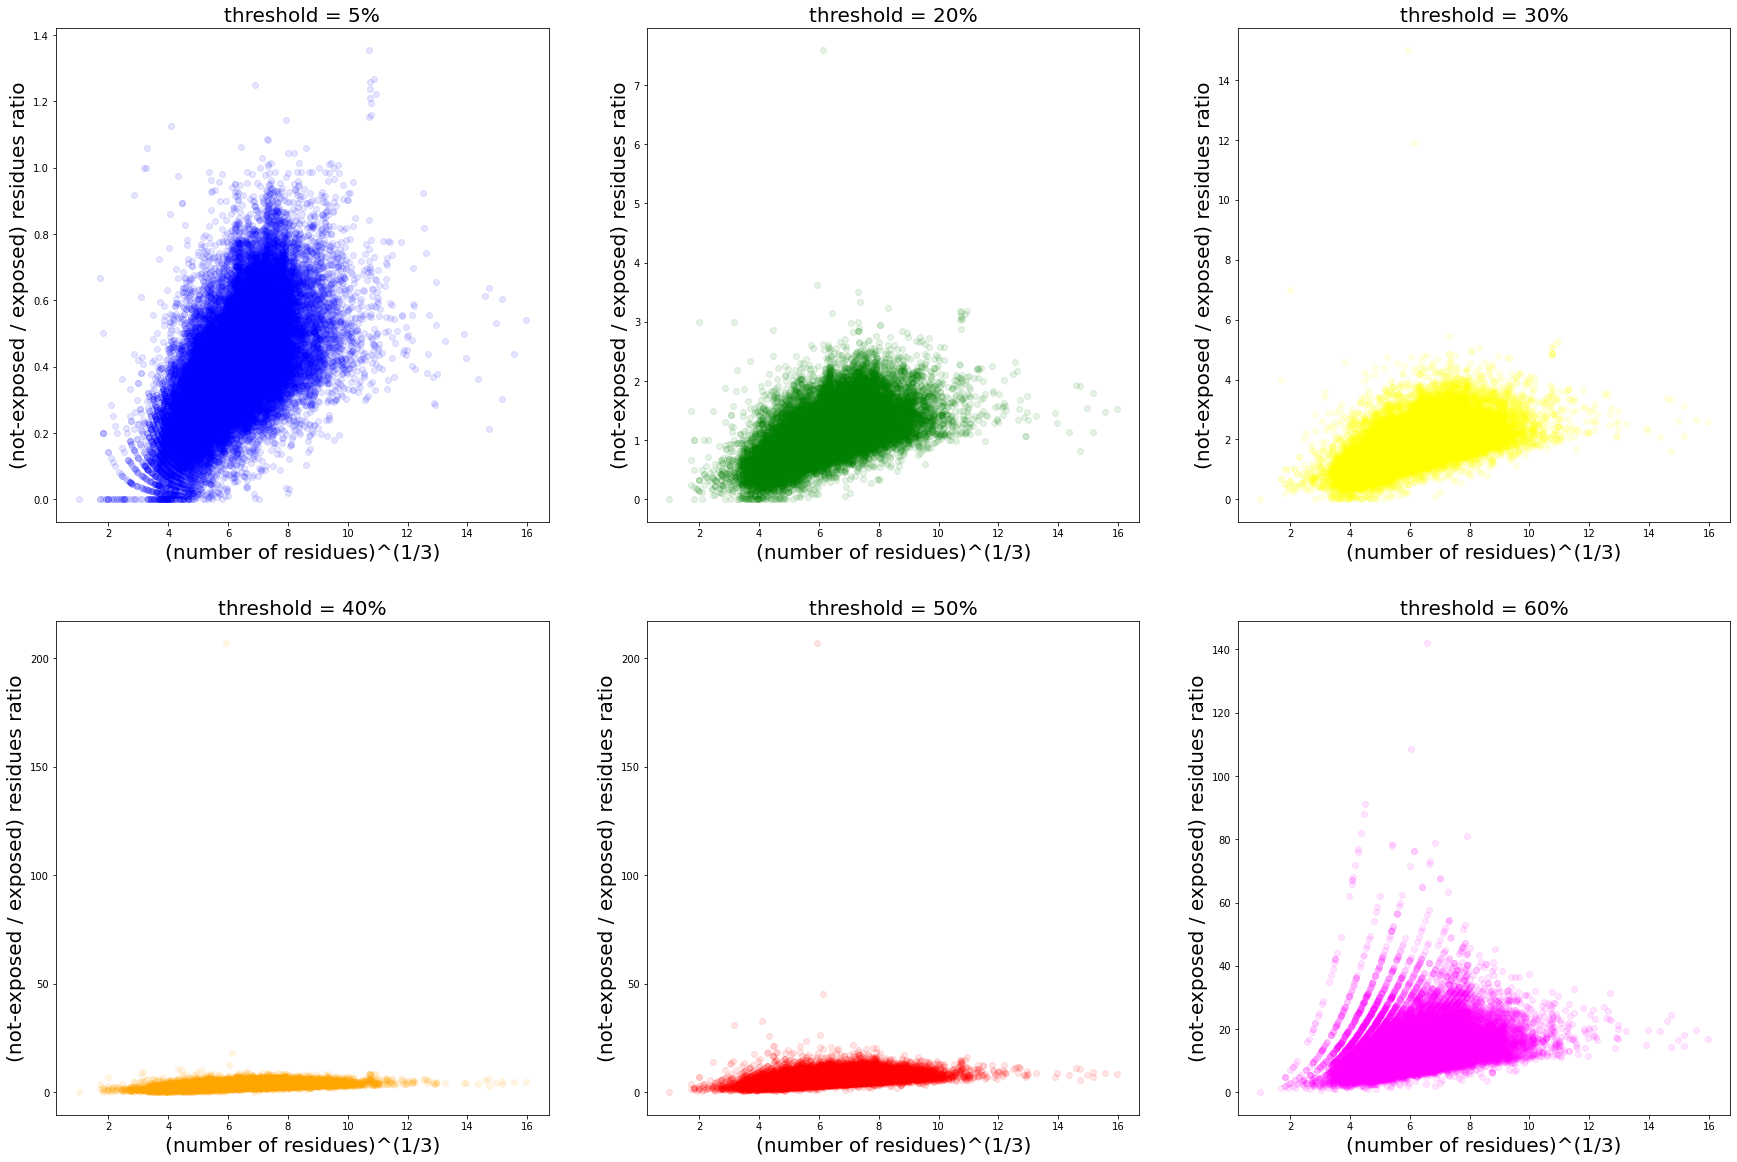

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))

plot_names = ['threshold = ' + str(x) + '%' for x in [5, 20, 30, 40, 50, 60]]
plot_cols = ['exposed_' + str(x) for x in [5, 20, 30, 40, 50, 60]]
plot_colors = ['blue', 'green', 'yellow', 'orange', 'red', 'magenta']

x_vals = np.power(expose_dt['number_of_residues'], 1/3)
for plot_ind in range(6):
    plt.subplot(2, 3, plot_ind + 1)
    column = plot_cols[plot_ind]
    y_vals = expose_dt[column] / (expose_dt['number_of_residues'] - expose_dt[column])
    color = plot_colors[plot_ind]
    plt.scatter(x_vals, y_vals, alpha=.1, c=color)
    plt.xlabel('(number of residues)^(1/3)', fontsize=20)
    plt.ylabel('(not-exposed / exposed) residues ratio', fontsize=20)
    plt.title(plot_names[plot_ind], fontsize=20)


plt.show()

При граничном значении 5% мы сталкиваемся с тем, что число определенных таким образом экспонированных остатков приблизительно равняется общему числу остатков в белке, таким образом, в выбранных координатах мы будем видеть (помимо основной зависимости) обратную кубическую зависимость. При граничном значении 60%, наоборот, -- почти все остатки считаются нами неэкспонированными, поэтому мы снова будем видеть кубическую зависимость помимо основной. Эти граничные значения можно считать некорректно определенными. При остальных разделительных значениях экспонированности мы видим ожидаемую положительную корреляцию, однако, даже, если она в среднем линейная, ее дисперсия крайне велика. Можно предположить, что видимое облако точек складывается из многих прямых, которые возникали бы, если белки имели формы эллипсоидов с разными радиусами (действительно, края облаков имеют достаточно ровные прямые границы).

### Вторичная структура, аннотированная с помощью DSSP.

Теперь мы попытаемся установить некоторые более тонкие закономерности -- уже на уровне вторичной структуры. <br>
Попробуем выяснить, отличаются ли по своей экспонированности основные элементы вторичной структуры. Построим распределения значений (площадь экспонированной поверхности / количество остатков в данном типе структуры) для альфа-спиралей, бета-листов и петель, аннотированных с помощью DSSP. Значения SASA для отдельных остатков будем нормировать на максимально возможные для них значения (при этом будем учитывать только некраевые остатки).

In [7]:
aa_names = [aa_triple_to_single[aa.upper()] for aa in aa_list]
aa_codes = dict()
for ind, aa in enumerate(aa_names):
    aa_codes[aa] = ind
    
def CountSecondaryStructureStatistics():
    dssp_codes = ['G', 'H', 'I', 'T', 'E', 'B', 'S', 'C']
    secondary_structure_area = [['pdb_id', 'secondary_structure', 'amino_acid', 'number_of_residues', 'surface_area']]

    for ind, f in enumerate(tqdm(os.listdir(freesasa_dir), desc='processing freeSASA & DSSP files')):
        pdbid = f.split('.')[0]
        surfarea = dict()
        chain = pisces_prot_to_chain[pdbid]
        residue_indices = list()
        with open(freesasa_dir + f, 'r') as sasa_file:
            for line in sasa_file:
                if (line.startswith('#') or line == '\n'):
                    continue
                l = line.strip().split()
                if (l[1] not in chain):
                    continue
                if (l[3] not in aa_triple_to_single):
                    continue
                try:
                    residue_indices.append(int(l[2]))
                except ValueError:
                    residue_indices.append(int(l[2][:-1]))

                surfarea[aa_triple_to_single[l[3]] + '_' + l[2]] = float(l[5]) / aa_to_maxasa[l[3]]

        n_end = min(residue_indices)
        c_end = max(residue_indices)
        
        surfaces = dict()
        residues = dict()
        for dssp_code in dssp_codes:
            surfaces[dssp_code] = [0 for i in range(len(aa_names))]
            residues[dssp_code] = [0 for i in range(len(aa_names))]

        with open(dssp_dir + pdbid + '.dssp', 'r') as dssp_file:
            for line in dssp_file:
                l = line.strip().split()
                if (l[0] not in chain):
                    continue
                aa = l[2].upper() + '_' + l[1]
                if ((aa not in surfarea) or (l[2].upper() not in aa_codes)):
                    continue
                if (int(l[1]) == n_end or int(l[1]) == c_end):
                    continue
                struct_type = l[3]
                surfaces[struct_type][aa_codes[l[2].upper()]] += surfarea[aa]
                residues[struct_type][aa_codes[l[2].upper()]] += 1

        for dssp_code in dssp_codes:
            for aa in aa_names:
                if (residues[dssp_code][aa_codes[aa]] == 0):
                    continue
                secondary_structure_area.append([pdbid, dssp_code, aa, \
                                                 residues[dssp_code][aa_codes[aa]], \
                                                 surfaces[dssp_code][aa_codes[aa]]])
    
    return secondary_structure_area

all_dt = CountSecondaryStructureStatistics()
all_dt = pd.DataFrame(all_dt[1:], columns = all_dt[0])

processing freeSASA & DSSP files: 100%|██████████| 40910/40910 [00:43<00:00, 934.45it/s] 


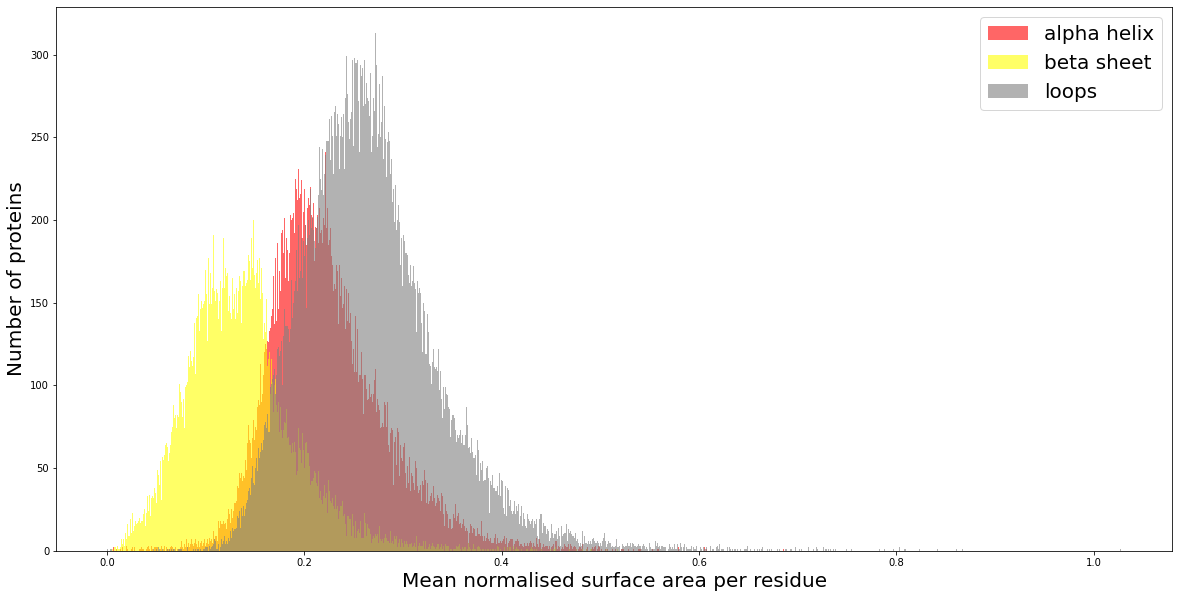

In [8]:
second_struct = all_dt.pivot_table(index='pdb_id',columns='secondary_structure',aggfunc='sum')
second_struct.columns = second_struct.columns.droplevel()
second_struct.columns.name = None
second_struct.reset_index(inplace=True)
colnames=list(second_struct.columns[1:9])
second_struct.columns = ['pdb_id'] + [cl + '_n' for cl in colnames] + [cl + '_s' for cl in colnames]


alpha = second_struct[['H_n', 'H_s']].dropna()
beta = second_struct[['E_n', 'E_s']].dropna()
loop = second_struct[['C_n', 'C_s']].dropna()

plt.figure(figsize=(20, 10))
plt.hist(alpha['H_s'] / alpha['H_n'], bins=1000, alpha=.6, color='red', label='alpha helix')
plt.hist(beta['E_s'] / beta['E_n'], bins=1000, alpha=.6, color='yellow', label='beta sheet')
plt.hist(loop['C_s'] / loop['C_n'], bins=1000, alpha=.6, color='gray', label='loops')
plt.xlabel('Mean normalised surface area per residue', fontsize=20)
plt.ylabel('Number of proteins', fontsize=20)
plt.legend(fontsize=20)
plt.show()

Мы видим, что остатки, входящие в состав бета-листов, как правило, недоступны для окружающей воды. Остатки петель, напротив, часто находятся на поверхности. Альфа-спирали, судя по этому графику, занимают промежуточное положение. Отметим также, что во всех распределениях правый хвост (соответствующий большей экспонированности) тяжелее левого. Это может быть 'техническим' следствием алгоритма 'rolling ball' и нашей процедуры нормировки. С другой стороны, это может быть следствием более частой встречаемости частично экспонированных для воды остатков, чем полностью скрытых от нее остатков. <br>

Интересно рассмотреть также и более редкие типы вторичной структуры, хотя, вероятно, в этом случае мы начинаем сильно зависеть от свойств алгоритма DSSP.

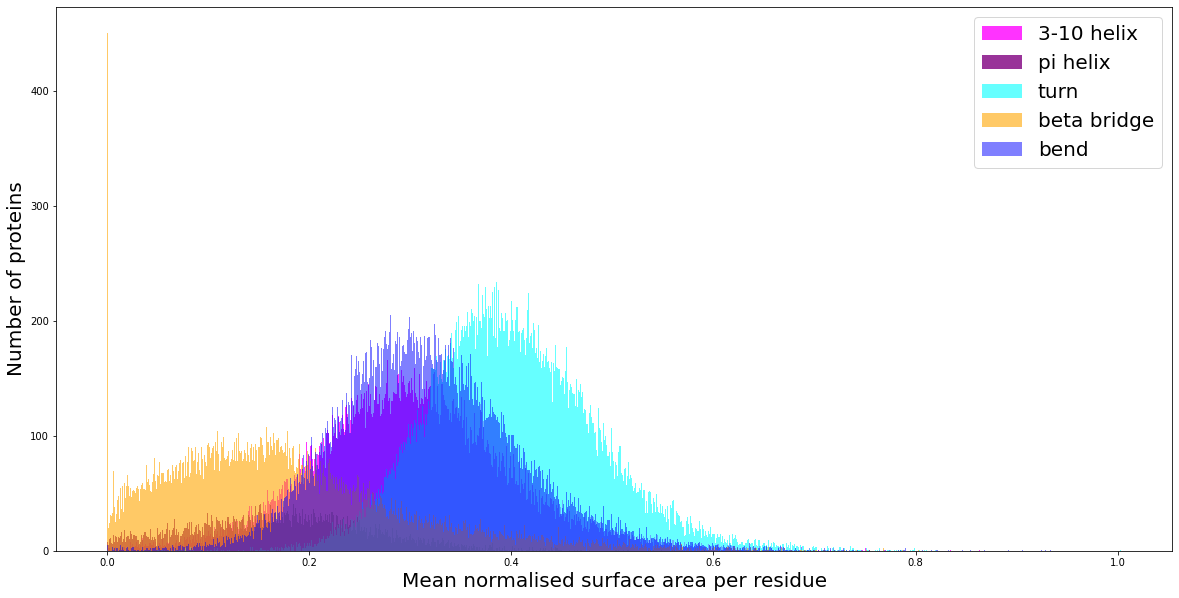

In [9]:
helix_310 = second_struct[['G_n', 'G_s']].dropna()
pi_helix = second_struct[['I_n', 'I_s']].dropna()
turn = second_struct[['T_n', 'T_s']].dropna()
beta_bridge = second_struct[['B_n', 'B_s']].dropna()
bend = second_struct[['S_n', 'S_s']].dropna()

plt.figure(figsize=(20, 10))
plt.hist(helix_310['G_s'] / helix_310['G_n'], bins=1000, alpha=.8, color='magenta', label='3-10 helix')
plt.hist(pi_helix['I_s'] / pi_helix['I_n'], bins=1000, alpha=.8, color='purple', label='pi helix')
plt.hist(turn['T_s'] / turn['T_n'], bins=1000, alpha=.6, color='cyan', label='turn')
plt.hist(beta_bridge['B_s'] / beta_bridge['B_n'], bins=1000, alpha=.6, color='orange', label='beta bridge')
plt.hist(bend['S_s'] / bend['S_n'], bins=1000, alpha=.5, color='blue', label='bend')

plt.xlabel('Mean normalised surface area per residue', fontsize=20)
plt.ylabel('Number of proteins', fontsize=20)
plt.legend(fontsize=20)

plt.show()

Распределения, которые мы видим, достаточно хорошо согласуются с интуицией. Для участков, отвечающих изгибам белковой цепи (bend, turn) характерны большие значения экспонированности. B-мостики характерны для внутренних участков белка. Интересно так же, что именно к этому типу вторичной структуры DSSP относит абсолютно не экспонированный остатки (более 400 белков с такими остатками представлены на графике вертикальным столбцом в нуле). Сравним на отдельном графике три вида спиралей:

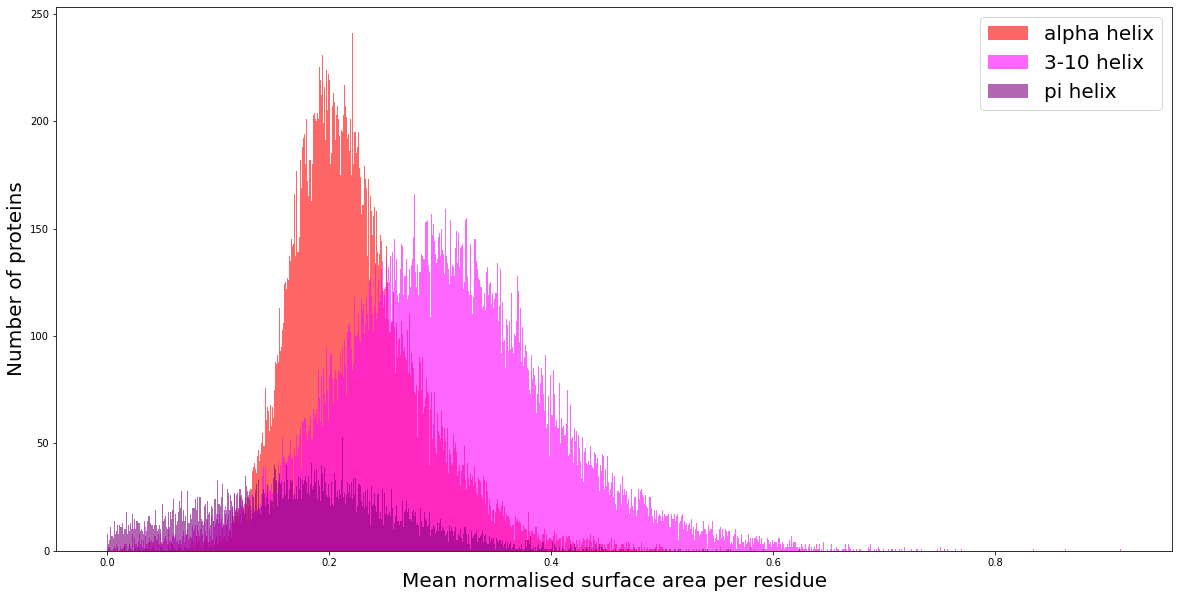

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(alpha['H_s'] / alpha['H_n'], bins=1000, alpha=.6, color='red', label='alpha helix')
plt.hist(helix_310['G_s'] / helix_310['G_n'], bins=1000, alpha=.6, color='magenta', label='3-10 helix')
plt.hist(pi_helix['I_s'] / pi_helix['I_n'], bins=1000, alpha=.6, color='purple', label='pi helix')
plt.xlabel('Mean normalised surface area per residue', fontsize=20)
plt.ylabel('Number of proteins', fontsize=20)
plt.legend(fontsize=20)
plt.show()

При выполнении практикума по вторичной структуре мы сталкивались с ситуациями, когда DSSP ошибочно предсказывает редкие виды спиралей там, где должна быть альфа-спираль. Однако, если мы верим DSSP в его аннотации, то надо признать, что экспонированность спиралей значительно отличается. Самые редкие -- пи-спирали сильнее всего погружены внутрь белка. Достаточно редкие 3-10 спирали, напротив часто оказываются на периферии. Альфа-спирали занимают промежуточное положение. Кроме того, разброс значений средней экспонированности остатков для альфа-спиралей самый маленький (не исключено, что большой разброс значений для остальных спиралей возникает из-за ошибок их определения с помощью DSSP). <br>

Мы не можем исключить, что экспонированность вторичной структуры является следствием ее аминокислотных предпочтений. Например, возможно, что в состав пи-спирали чаще входят более гидрофобные аминокислоты, которые в то же время редко являются экспонированными. Можно, конечно, установить, какие аминокислоты характерны для каждого типа вторичной структуры:

processing DSSP files: 100%|██████████| 40910/40910 [00:11<00:00, 3582.07it/s]


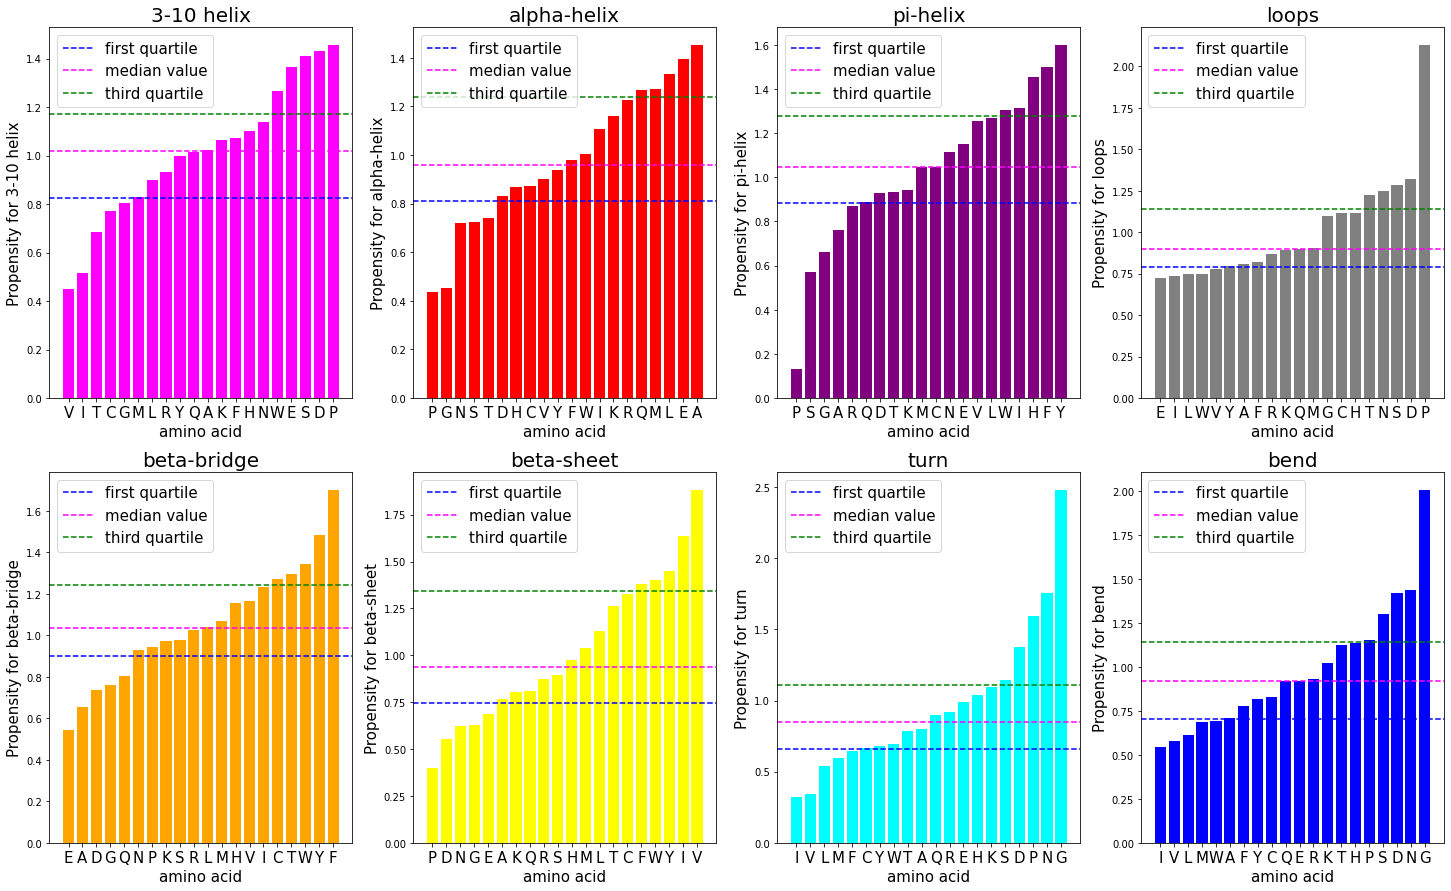

In [11]:
aa_names = [aa_triple_to_single[aa.upper()] for aa in aa_list]
aa_codes = dict()
for ind, aa in enumerate(aa_names):
    aa_codes[aa] = ind
dssp_codes = {'G':1, 'H':2, 'I':3, 'T':4, 'E':5, 'B':6, 'S':7, 'C':8}
dssp_list = ['G', 'H', 'I', 'T', 'E', 'B', 'S', 'C']
aa_count_dt = [[aa_names[j]] + [0 for i in range(len(dssp_codes))] for j in range(len(aa_names))]

for ind, f in enumerate(tqdm(os.listdir(dssp_dir), desc='processing DSSP files')):  
    pdbid = f.split('.')[0]
    chain = pisces_prot_to_chain[pdbid]
    with open(dssp_dir + pdbid + '.dssp', 'r') as dssp_file:
        for line in dssp_file:
            l = line.strip().split()
            if (l[0] not in chain):
                continue
            aa = l[2].upper()
            if (aa not in aa_codes):
                continue
            dssp_struct = l[3]
            aa_count_dt[aa_codes[aa]][dssp_codes[dssp_struct]] += 1
aa_count_dt = pd.DataFrame(aa_count_dt, columns=['aa'] + dssp_list)
aa_count_dt = aa_count_dt.set_index('aa')

def CountPropensity(n_ik, n_i, N_k, N):
    return (n_ik/n_i) / (N_k/N)
propensity_table = [['aa'] + dssp_list]
N = aa_count_dt.sum().sum()
for aa in aa_count_dt.T:
    new_list = [aa]
    for struct in aa_count_dt:
        n_ik = aa_count_dt.T[aa][struct]
        n_i = aa_count_dt.T[aa].sum()
        N_k = aa_count_dt[struct].sum()
        new_list.append(CountPropensity(n_ik, n_i, N_k, N))
    propensity_table.append(new_list)
propensity = pd.DataFrame(propensity_table[1:], columns=propensity_table[0])
propensity = propensity.set_index('aa')

plt.figure(figsize=(25, 15))
plt.subplot(2, 4, 1)
plt.title('Amino acid propensities for secondary structures', fontsize=20)
dssp_colors = {'G':'magenta', 'H':'red', 'I':'purple', 'C':'gray',
          'B':'orange', 'E':'yellow', 'T':'cyan', 'S':'blue'}
dssp_titles = {'G':'3-10 helix', 'H':'alpha-helix', 'I':'pi-helix', 'C':'loops',
          'B':'beta-bridge', 'E':'beta-sheet', 'T':'turn', 'S':'bend'}

for struct_ind, struct in enumerate(['G', 'H', 'I', 'C', 'B', 'E', 'T', 'S']):
    propensity = propensity.sort_values(struct)
    plt.subplot(2, 4, struct_ind + 1)
    plt.bar(np.array(propensity.T.columns), np.array(propensity[struct]), color=dssp_colors[struct])
    plt.xlabel('amino acid', fontsize=15)
    plt.ylabel('Propensity for ' + dssp_titles[struct], fontsize=15)
    plt.xticks(size=15)
    plt.axhline(y=propensity[struct].quantile(0.25), color = 'blue', linestyle='--', label = 'first quartile')
    plt.axhline(y=propensity[struct].quantile(), color = 'magenta', linestyle='--', label = 'median value')
    plt.axhline(y=propensity[struct].quantile(0.75), color = 'green', linestyle='--', label = 'third quartile')
    plt.legend(fontsize=15)
    plt.title(dssp_titles[struct], fontsize=20)

plt.show()

Далее можно посчитать распределения экспонированностей для каждой аминокислоты, и определить вклад эффекта экспонированности аминокислот в экспонированность вторичной структуры (мы сделаем анализ экспонированности отдельных аминокислот чуть ниже). Однако быстрее будет зафиксировать лишь один какой-то остаток и посчитать по нему статистику для разных типов вторичной структуры. Так мы автоматически исключим из наших результатов эффект, возникающий из-за разного аминокислотного состава. <br>
Проделаем такой сравнительный анализ для трех видов спиралей. Разумеется, хочется взять остаток, который встречается часто во всех трех спиралях, чтобы иметь дело с 'характерным' представителем спирали. Однако, как видно по графику предпочтений выше, это не так просто сделать. Существуют всего три остатка (глутамат, фенилаланин, триптофан), которые часто (выше медианы) встречаются во всех трех спиралях. Посмотрим, как на экспонированность этих остатков влияет принадлежность к тому, или иному типу спирали:


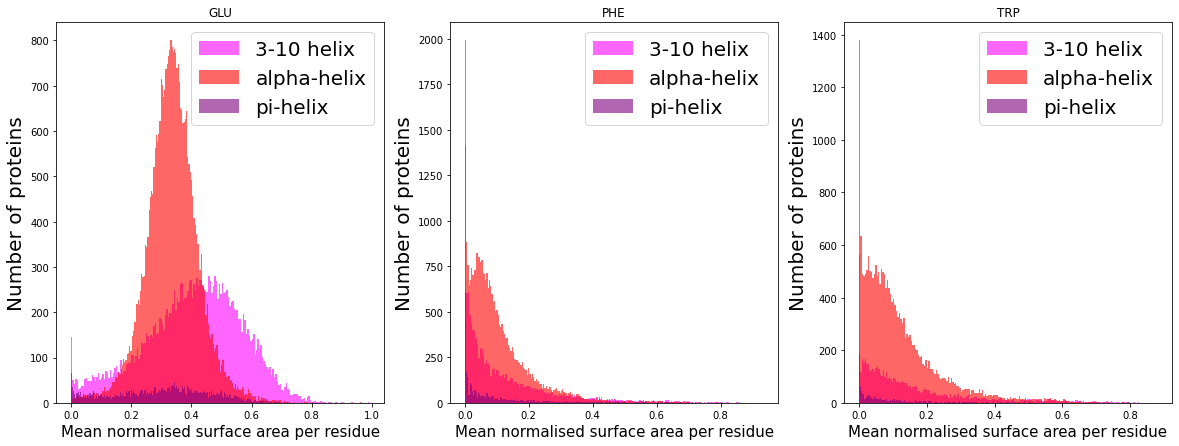

In [12]:
helix_aas = ['E', 'F', 'W']
helix_codes = ['G', 'H', 'I']

lc_dt = all_dt.loc[(all_dt['secondary_structure'].isin(helix_codes)) & \
                         (all_dt['amino_acid'].isin(helix_aas))]
plt.figure(figsize=(20, 7))
for ind, aa in enumerate(helix_aas):
    plt.subplot(1, 3, ind+1)
    for helix in helix_codes:
        hist_dt = lc_dt.loc[(lc_dt['secondary_structure'] == helix) & (lc_dt['amino_acid'] == aa)].dropna()
        plt.hist(hist_dt['surface_area'] / hist_dt['number_of_residues'], bins = 200, \
                 alpha=.6, color=dssp_colors[helix], label=dssp_titles[helix])
        plt.title(aa_single_to_triple[aa])
        plt.xlabel('Mean normalised surface area per residue', fontsize=15)
        plt.ylabel('Number of proteins', fontsize=20)
        plt.legend(fontsize=20)
plt.show()

Из приведенных графиков можно сразу сделать два предположения. Во-первых, судя по распределениям для глутамата, сама по себе структура вносит вклад в экспонированность. Причем в данном случае спирали 3-10 спираль и альфа-спираль отличаются по своим распределениям так же, как и в случае рассмотрения всех вообще аминокислот. Распределение пи-спирали (график для глутамата) близко к равномерному (она редкая, для нее мало данных), тем не менее оно смещено к области низкой экспонированности. В случае фенилаланина и триптофана мы видим, что сами по себе аминокислоты экспонированы очень слабо (вероятно, вследствие высокой гидрофобности), но даже на фоне их слабой экспонированности можно различить вклад разных структур. Можно сделать вывод по этим анализом, что мы действительно имеем дело со свойствами структур, а не только аминокислот, хотя как уже здесь видно, между разными аминокислотами экспонированность сильно разнится. <br>

Проведем аналогичный сравнительный анализ для альфа-спиралей, бета-листов и петель. Чтобы максимально полно описать различия между этими структурами, рассмотрим теперь все аминокислотные остатки по-отдельности и подпишем для каждой аминокислоты, для каких структур она является предпочтительной (т.е. значение propensity выше медианного):

plotting amino acids: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


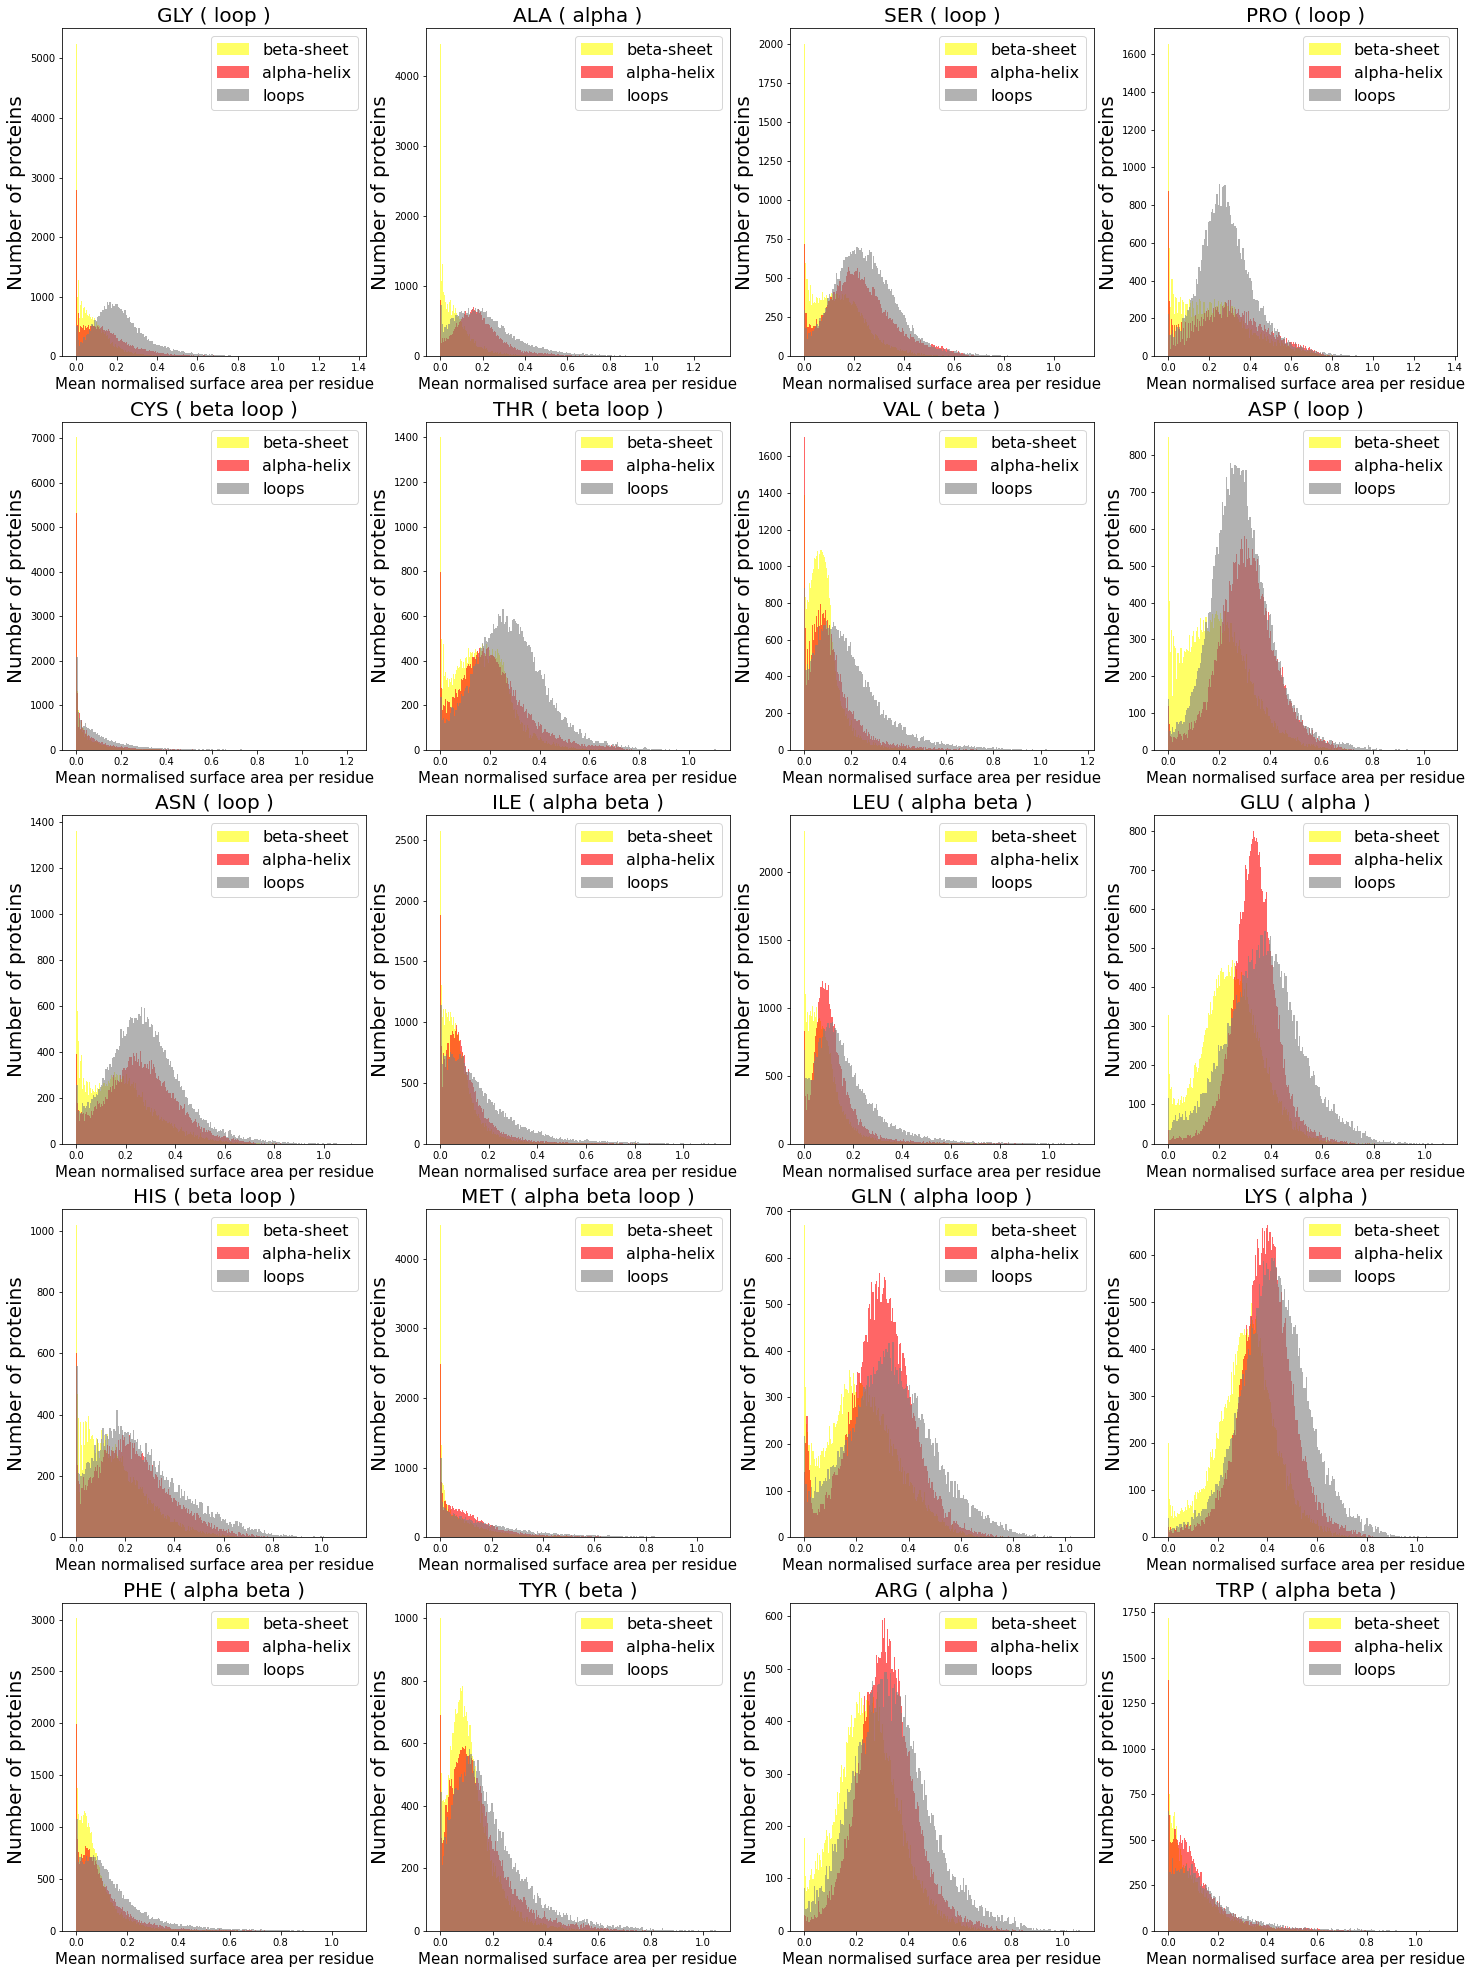

In [13]:
alpha_prop = list(propensity.sort_values('H')['H'].index)[10:]
beta_prop = list(propensity.sort_values('E')['E'].index)[10:]
loop_prop = list(propensity.sort_values('C')['C'].index)[10:]

ss_codes = ['E', 'H', 'C']
lc_dt = all_dt.loc[all_dt['secondary_structure'].isin(ss_codes)]

plt.figure(figsize=(25, 35))
for ind, aa in enumerate(tqdm(aa_names, desc='plotting amino acids')):
    plt.subplot(5, 4, ind+1)
    for ss in ss_codes:
        hist_dt = lc_dt.loc[(lc_dt['secondary_structure'] == ss) & (lc_dt['amino_acid'] == aa)].dropna()
        plt.hist(hist_dt['surface_area'] / hist_dt['number_of_residues'], bins = 200, \
                 alpha=.6, color=dssp_colors[ss], label=dssp_titles[ss])
        plt.xlabel('Mean normalised surface area per residue', fontsize=15)
        plt.ylabel('Number of proteins', fontsize=20)
        plt.legend(fontsize=16)
        full_title = ' ( '
        if (aa in alpha_prop):
            full_title += 'alpha '
        if (aa in beta_prop):
            full_title += 'beta '
        if (aa in loop_prop):
            full_title += 'loop '
        full_title += ')'
        plt.title(aa_single_to_triple[aa] + full_title, fontsize=20)
plt.show()

Мы видим, что на некоторых остатках различия в экспонированности основных типов вторичной структуры довольно хорошо заметны. К таким аминокислотам относятся глутамат, аспатат, глутамин, треонин, валин, лейцин. Как и выше, когда мы рассматривали вместе все аминокислоты, наименее экспонированными являются бета-листы, наиболее экспонированными -- петли, альфа-спирали находятся посередине. Почти на всех аминокислотах заметно, что принадлежность к бета-листу скоррелирована с низкой экспонированностью. Вместе с тем, некоторые аминокислоты фактически одинаково хорошо экспонированы независимо от того, находятся они в альфа-спирали, или в петле: хорошо это заметно, например на аргинине. Заметим, что для характерные для бета-листов аминокислоты: валин, изолейцин, тирозин, триптофан, фенилаланин, являются сами по себе достаточно плохо экспонированными (независимо от структуры, в которой они находятся). Одновременно характерные для петель аминокислоты: пролин, аспартат, серин, напротив, являются достаточно хорошо экспонированными в составе любой вторичной структуры (но все же лучше всего именно в составе петель).
<br>
Обратим внимание на характерные в первую очередь для альфа-спиралей и бета-листов абсолютно не экспонированные остатки -- см. на столбцы в нуле (стоит добавить, что согласно нашей процедуре построения графиков, мы исключали данные для остатков, которые в данный тип структуры не попали ни разу, так что столбец в нуле означает именно нулевую экспонированность, а не отсутствие остатка в данной структуре в данном белке). Самый яркий пример здесь цистеин, который в составе бета-листов приблизительно 6 тысячи белков, альфа-спиралей ~5 тысяч белков, петель ~1.5 тысяч белков является полностью спрятанным от воды. Можно предположить, что цистеин часто используется в белках для построения S-S мостиков, и, соответственно, почти что не образует водородных связей с водой, спрятан от нее. В левом ряду остатки (за исключением фениланина) являются характерными именно для петель, но при этом спрятаны от растворителя в основном, когда находятся в составе альфа-спиралей и бета-листов. <br>
Мы хотим подвести итог: мы видели здесь, что сама по себе вторичная структура определяет степень экспонированности для некоторых остатков. Вместе с тем, характерные для (плохо) хорошо экспонированной в среднем вторичной структуры  аминокислоты имеют сами по себе (=независимо от структуры, в состав которой они входят) (плохую) хорошую экспонированность. Таким образом, оба фактора: свойства самого остатка и принадлежность его к какой-то вторичной структуре -- определяют свойства остатков быть экспонированными, или неэкспонированными.
<br>

Еще один интересный анализ состоит в том, чтобы соотнести propensity и медианные значения доступной для растворителя площади для каждого типа вторичной структуры:

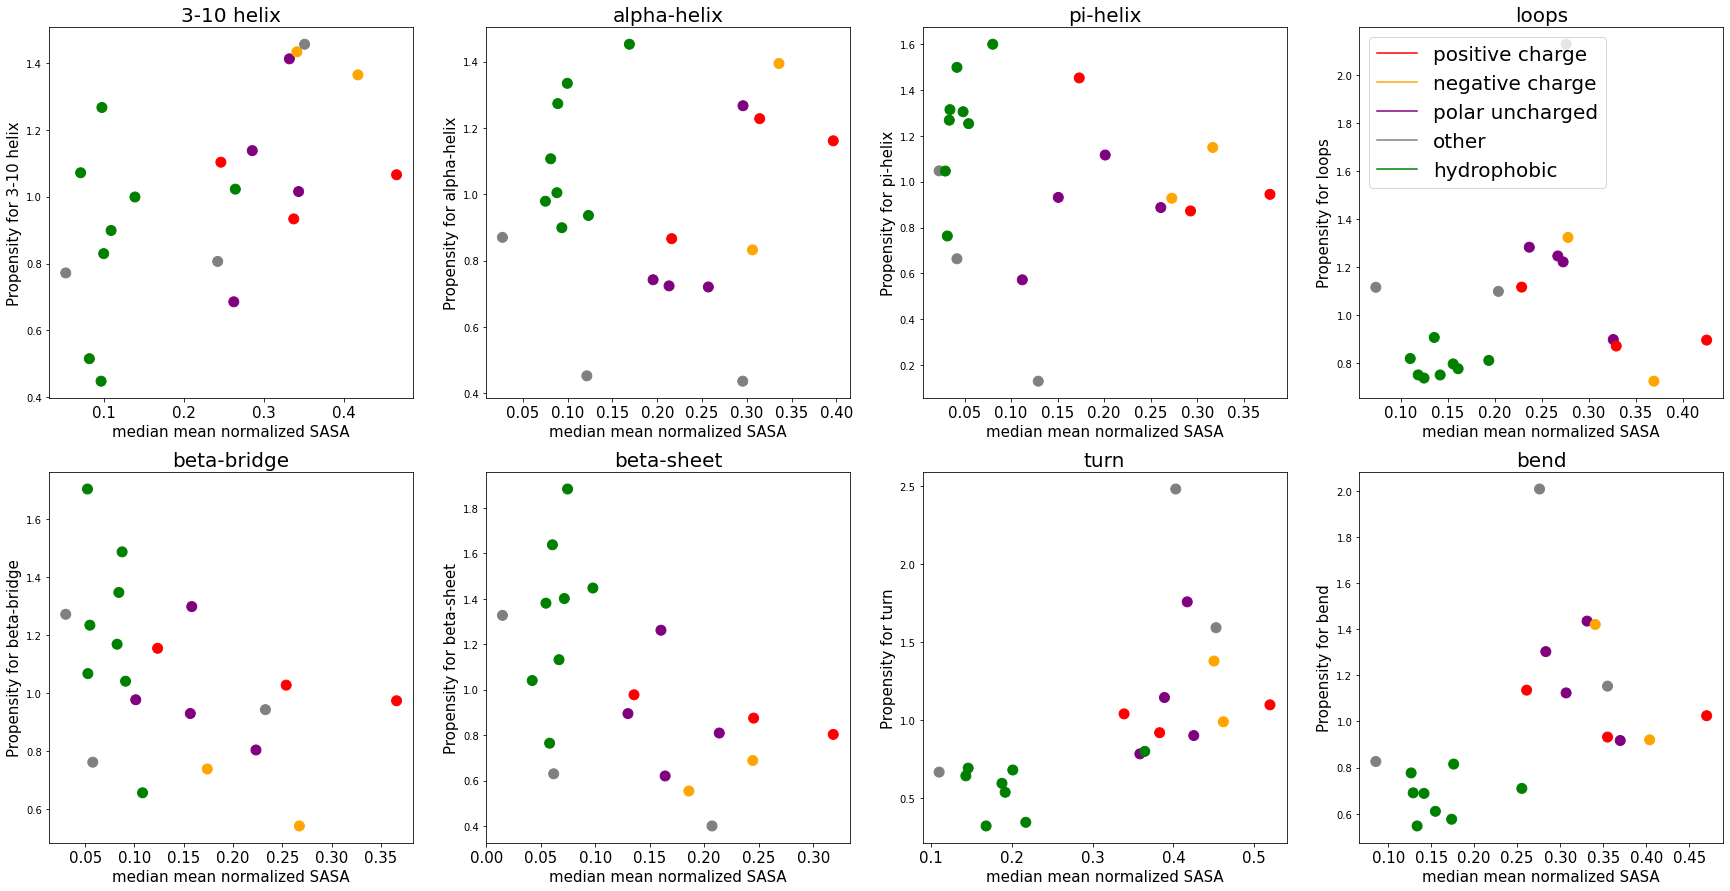

In [14]:
from matplotlib.lines import Line2D

aa_properties = {'R':'positive charge', 'H':'positive charge', 'K':'positive charge',
                 'D':'negative charge', 'E':'negative charge',
                 'S':'polar uncharged', 'T':'polar uncharged', 'N':'polar uncharged', 'Q':'polar uncharged',
                 'C':'other', 'U':'other', 'G':'other', 'P':'other',
                 'A':'hydrophobic','V':'hydrophobic','I':'hydrophobic','L':'hydrophobic','M':'hydrophobic',
                 'F':'hydrophobic','Y':'hydrophobic','W':'hydrophobic'}
properties_to_colors = {'positive charge':'red', 'negative charge':'orange',
                        'polar uncharged':'purple','other':'gray', 'hydrophobic':'green'}
aa_to_colors = dict()
for aa in aa_names:
    aa_to_colors[aa] = properties_to_colors[aa_properties[aa]]

plt.figure(figsize=(30, 15))
plt.subplot(2, 4, 1)
plt.title('Amino acid propensities for secondary structures', fontsize=20)
dssp_colors = {'G':'magenta', 'H':'red', 'I':'purple', 'C':'gray',
          'B':'orange', 'E':'yellow', 'T':'cyan', 'S':'blue'}
dssp_titles = {'G':'3-10 helix', 'H':'alpha-helix', 'I':'pi-helix', 'C':'loops',
          'B':'beta-bridge', 'E':'beta-sheet', 'T':'turn', 'S':'bend'}

for struct_ind, struct in enumerate(['G', 'H', 'I', 'C', 'B', 'E', 'T', 'S']):
    
    prop = dict(propensity.sort_values(struct)[struct])
    dt = all_dt.loc[(all_dt['secondary_structure'] == struct)]

    str_aa_dt = dt.pivot_table(index='pdb_id',columns='amino_acid',aggfunc='sum')
    str_aa_dt.columns = str_aa_dt.columns.droplevel()
    str_aa_dt.columns.name = None
    str_aa_dt.reset_index(inplace=True)
    colnames=list(str_aa_dt.columns[1:21])
    str_aa_dt.columns = ['pdb_id'] + [cl + '_n' for cl in colnames] + [cl + '_s' for cl in colnames]
    
    medianlist = list()
    for aa in aa_names:
        medianlist.append([str_aa_dt[aa + '_s'].dropna() / str_aa_dt[aa + '_n'].dropna(), aa, prop[aa]])
    medianlist = sorted(medianlist, key=(lambda x: x[0].median()))
    sorted_names = [el[1] for el in medianlist]
    sorted_medians = [el[0].median() for el in medianlist]
    sorted_propensities = [el[2] for el in medianlist]

    plt.subplot(2, 4, struct_ind + 1)
    
    colorlist = [aa_to_colors[aa] for aa in sorted_names]
    labellist = [aa_properties[aa] for aa in sorted_names]
    
    plt.scatter(sorted_medians, sorted_propensities,color=colorlist,s=100)
    plt.xlabel('median mean normalized SASA', fontsize=15)
    plt.ylabel('Propensity for ' + dssp_titles[struct], fontsize=15)    
    plt.xticks(size=15)
    plt.title(dssp_titles[struct], fontsize=20)
    if (struct_ind == 3):
        legend_elements = [Line2D([0], [0], color=aa_to_colors[aa], label=aa_properties[aa],
                      markerfacecolor='blue') for aa in ['R', 'D', 'S', 'C', 'A']]
        plt.legend(handles=legend_elements, loc='upper left', shadow=False, fontsize=20)

plt.show()

Тут мы раскрасили аминокислоты по их свойствам. Наше главное наблюдение состоит в том, что в характерных для периферии белка структурах: turn, bend, loops наблюдается положительная корреляция между propensity и медианой по белкам средних значений доступной для растворителя площади поверхности для данной аминокислоты (некоторое исключение мы видим для петель: там в эту закономерность не вписываются заряженные остатки). В то же время для спрятанных внутри бета-листов и бета-мостов корреляция отрицательная. Это совершенно закономерно: для внутренних участков белка не нужны контакты с водой. То же самое мы видим, когда обращаем внимание на свойство аминокислот (кстати, по свойствам на этих графиках аминокислоты достаточно хорошо кластеризуются). Интересно так же отметить, что для всех трех видов спиралей паттерны расположения точек напоминают друг друга.
<br>
Наконец, построим распределения экспонированности остатков без учета принадлежности к вторичной структуре.

### Аминокислотные остатки

Построим распределения средних относительных доступных для растворителя площадей для аминокислотных остатков.

In [15]:
aa_dt = all_dt.pivot_table(index='pdb_id',columns='amino_acid',aggfunc='sum')
aa_dt.columns = aa_dt.columns.droplevel()
aa_dt.columns.name = None
aa_dt.reset_index(inplace=True)
colnames=list(aa_dt.columns[1:21])
aa_dt.columns = ['pdb_id'] + [cl + '_n' for cl in colnames] + [cl + '_s' for cl in colnames]

plotting amino acids: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


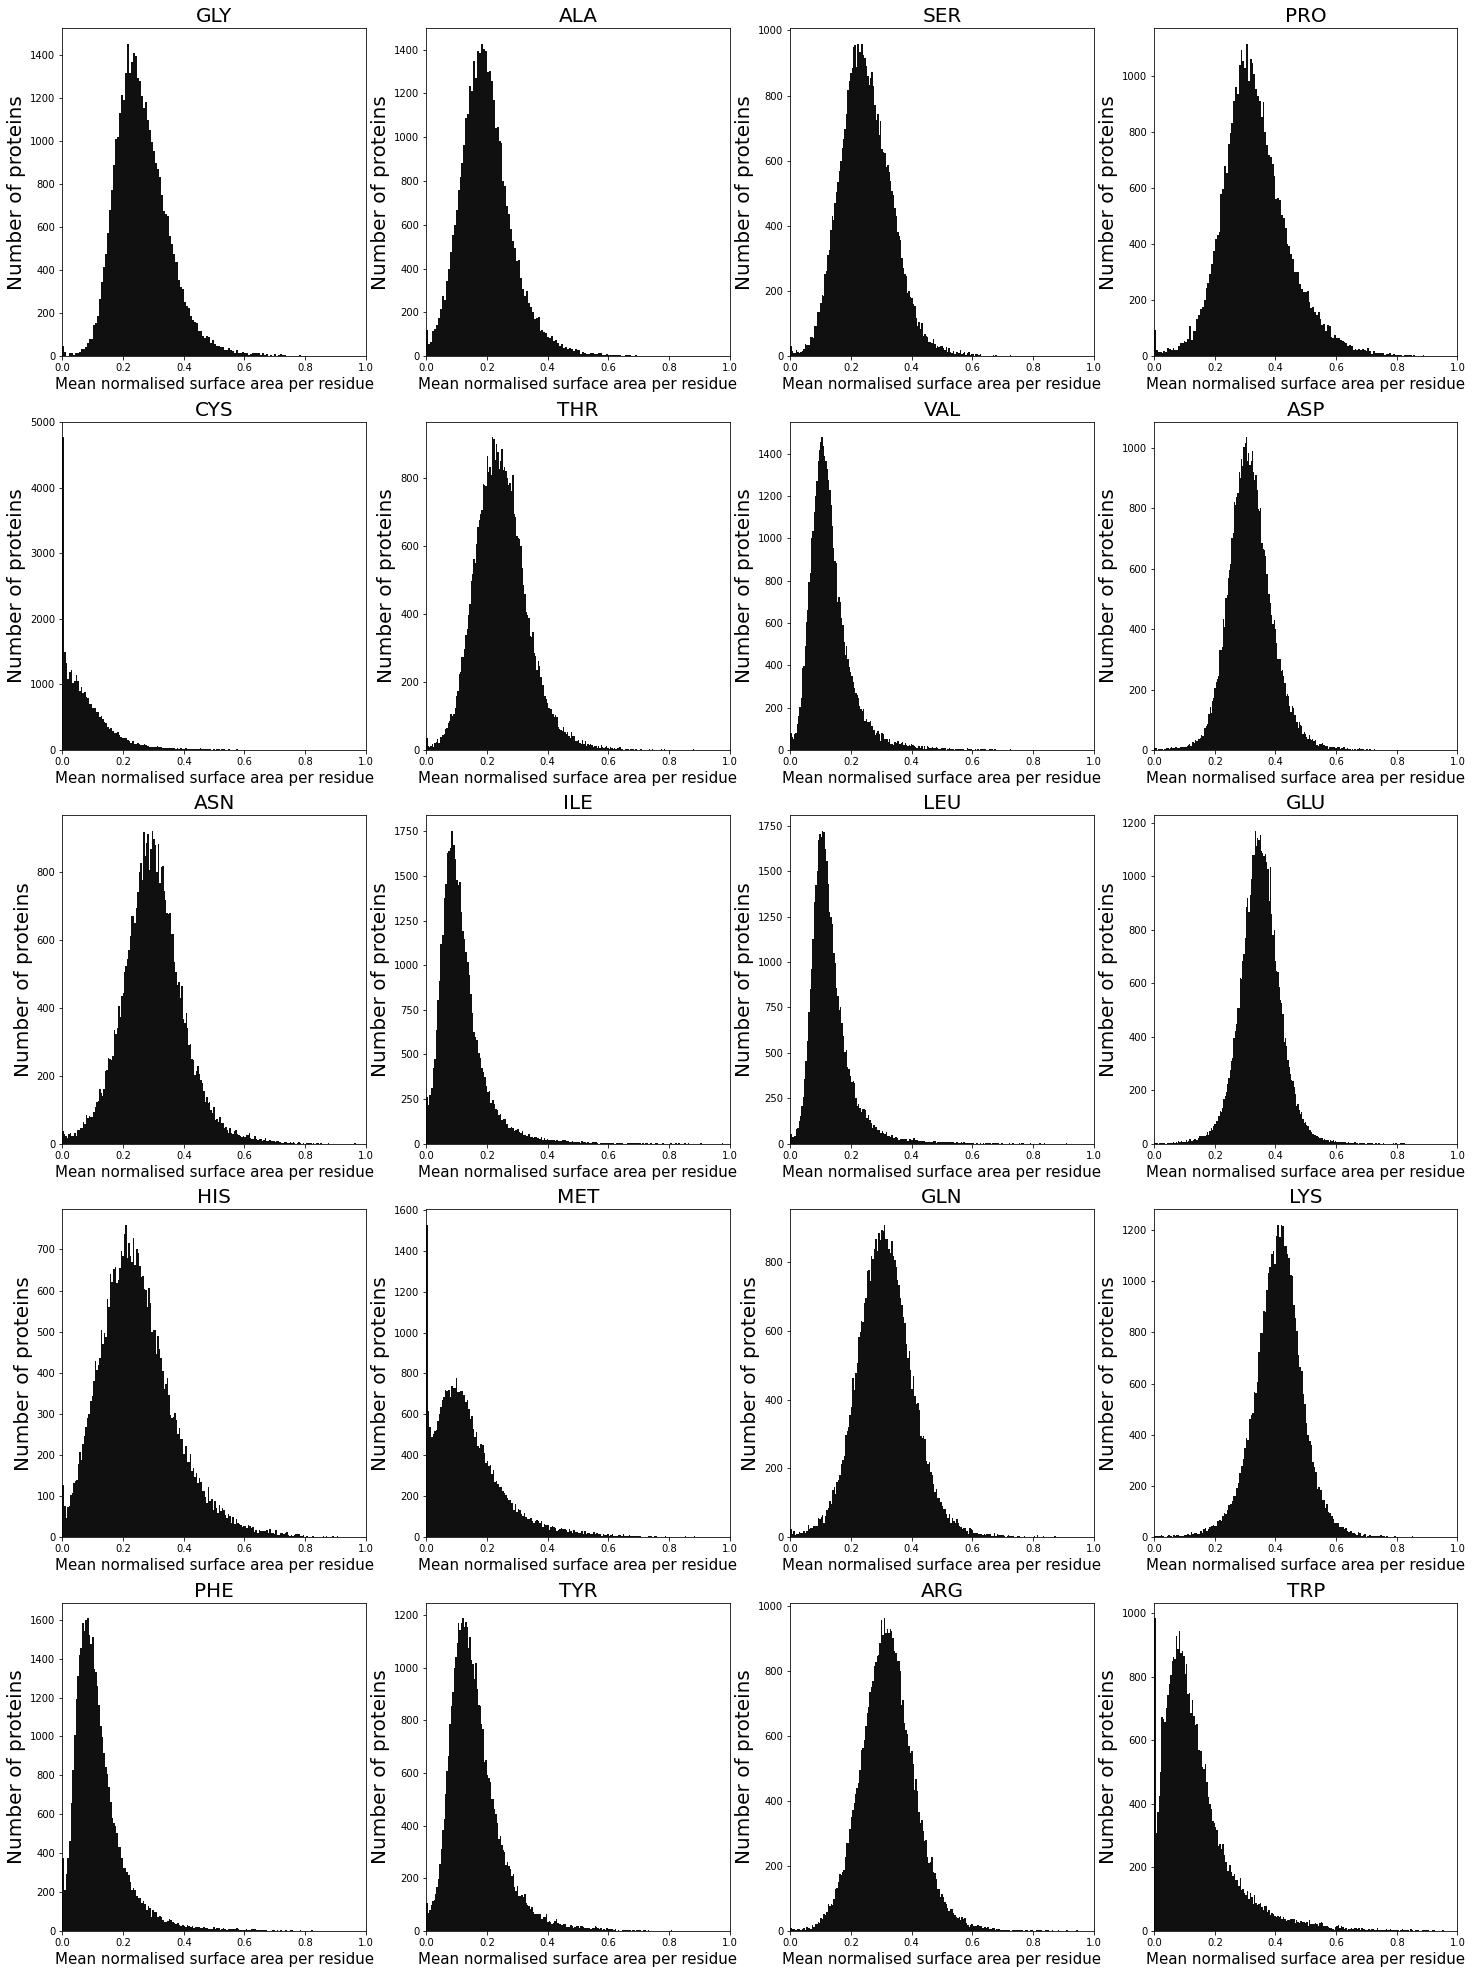

In [16]:
plt.figure(figsize=(25, 35))
for ind, aa in enumerate(tqdm(aa_names, desc='plotting amino acids')):
    plt.subplot(5, 4, ind+1)
    for ss in ss_codes:
        hist_dt = aa_dt[aa + '_s'].dropna() / aa_dt[aa + '_n'].dropna()
        plt.hist(hist_dt, bins = 200, \
                 alpha=.6, color='black')
        plt.xlim([0, 1])
        plt.xlabel('Mean normalised surface area per residue', fontsize=15)
        plt.ylabel('Number of proteins', fontsize=20)
        plt.title(aa_single_to_triple[aa], fontsize=20)
plt.show()

Видим, что распределения отличаются друг от друга, но почти все являются достаточно симметричными. Чтобы лучше были видны отличия, изобразим на одном графике квантили распределений:

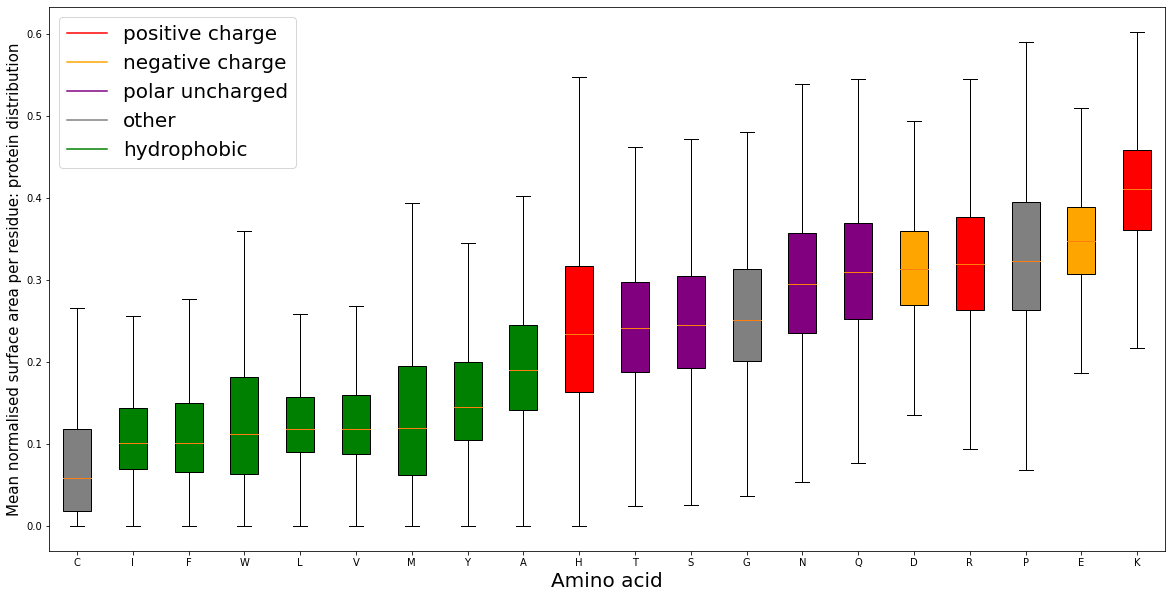

In [17]:
from matplotlib.lines import Line2D

aa_properties = {'R':'positive charge', 'H':'positive charge', 'K':'positive charge',
                 'D':'negative charge', 'E':'negative charge',
                 'S':'polar uncharged', 'T':'polar uncharged', 'N':'polar uncharged', 'Q':'polar uncharged',
                 'C':'other', 'U':'other', 'G':'other', 'P':'other',
                 'A':'hydrophobic','V':'hydrophobic','I':'hydrophobic','L':'hydrophobic','M':'hydrophobic',
                 'F':'hydrophobic','Y':'hydrophobic','W':'hydrophobic'}
properties_to_colors = {'positive charge':'red', 'negative charge':'orange',
                        'polar uncharged':'purple','other':'gray', 'hydrophobic':'green'}
aa_to_colors = dict()
for aa in aa_names:
    aa_to_colors[aa] = properties_to_colors[aa_properties[aa]]


boxplotlist = list()
for aa in aa_names:
    boxplotlist.append([aa_dt[aa + '_s'].dropna() / aa_dt[aa + '_n'].dropna(), aa, aa_to_colors[aa]])
boxplotlist = sorted(boxplotlist, key=(lambda x: x[0].median()))
sorted_names = [el[1] for el in boxplotlist]
sorted_list = [el[0] for el in boxplotlist]
sorted_colors = [el[2] for el in boxplotlist]



fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
boxes = ax.boxplot(sorted_list, showfliers=False, patch_artist=True)

for ind, box in enumerate(boxes["boxes"]):
    box.set(facecolor = sorted_colors[ind])
    
plt.xticks([i+1 for i in range(20)], sorted_names)
plt.ylabel('Mean normalised surface area per residue: protein distribution', fontsize=15)
plt.xlabel('Amino acid', fontsize=20)

legend_elements = [Line2D([0], [0], color=aa_to_colors[aa], label=aa_properties[aa],
                      markerfacecolor='blue') for aa in ['R', 'D', 'S', 'C', 'A']]

ax.legend(handles=legend_elements, loc='upper left', shadow=False, fontsize=20)
plt.show()

Вполне закономерно: более гидрофобные аминокислоты имеют небольшие значения доступных для растворителя площадей поверхности, полярные и заряженные аминокислоты -- наоборот.